# Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [3]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [322]:
import numpy as np

mantissa_nbits = 12
guess_range=(-5.0, 5.0)
# the number of guess values in the guess range
secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = -0.531028635
print('secret_number =', secret_number)

secret_number = -0.531028635


## Receover the weight number in step-by-step

In [ ]:
import sys
sys.path.append("../")

from pybatina.weight_recovery import *
from pybatina.utils import *

### Correlation of mantissa

In [ ]:
guess_numbers = build_guess_values(component='mantissa', mantissa_nbits=mantissa_nbits, guess_range=guess_range)
known_inputs = build_input_values(mantissa_nbits=mantissa_nbits, component='mantissa')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
pd.Series(known_inputs).sort_values().reset_index(drop=True).plot(figsize=(15,6), marker='.')

In [ ]:
%%time
mantisa_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

In [ ]:
ax = mantisa_corr.sort_index().plot(figsize=(15,6), label='correlation')
ax.vlines(mantisa_corr.idxmax(), mantisa_corr.min(), mantisa_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, mantisa_corr.min(), mantisa_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [ ]:
mantisa_corr.sort_values(ascending=False).iloc[:10]

### Correlation exponent

In [ ]:
known_inputs = build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
guess_numbers = build_guess_values(component='exponent', numbers=mantisa_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(12,6), marker='.')

In [ ]:
%%time
mantisa_exp_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

In [ ]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6), label='correlation')
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [ ]:
mantisa_exp_corr.sort_values(ascending=False).iloc[:10]

### Correlation sign

In [ ]:
guess_numbers = build_guess_values(component='sign', numbers=mantisa_exp_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
known_inputs = build_input_values(component='sign')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(12,6), marker='^')

In [ ]:
%%time
full_number_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

In [ ]:
ax = full_number_corr.sort_index().plot(figsize=(15,6), label='correlation')
ax.vlines(full_number_corr.idxmax(), full_number_corr.min(), full_number_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [ ]:
print('Secret value = %f' % secret_number)
full_number_corr.sort_values(ascending=False).iloc[:10]

## Recover a secret number with helper function

In [ ]:
%%time
from weight_recovery_helper import *
full_number_corr = batina_recover_weight(secret_number=secret_number, 
                                         guess_range=guess_range,
                                         mantissa_nbits=mantissa_nbits,
                                         noise=None)
ax = full_number_corr.sort_index().plot(figsize=(15,6), label='correlation')
ax.vlines(full_number_corr.idxmax(), full_number_corr.min(), full_number_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [ ]:
print('Secret value = %f' % secret_number)
full_number_corr.sort_values(ascending=False).iloc[:10]

## Recover multiple secret numbers

In [ ]:
SECRET_VALUE='secret value'
GUESSED_VALUE = 'guessed value'
CORRELATION='correlation'
df_index = [SECRET_VALUE, GUESSED_VALUE, CORRELATION]

In [ ]:
def add_noise_to_signal(signal, snr, freq):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :param freq: frequency of noise 
    :return: signal with noise
    """
    sig_max = signal.max()
    sig_min = signal.min()
    return pd.Series(signal).apply(lambda x: x  +
                                   np.average(np.random.normal(0.0, (sig_max-sig_min)/snr, freq)))

In [ ]:
precision = 1e-3
n_secret_numbers = 1000
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
signal_to_noise_ratio = 0.5
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

## Batina without noise

### load existing DB

In [ ]:
# read the existing data
from os import path
try:
    fname = path.join(TEST_RESULT_DIR, 'batina_results-%d.csv' % mantissa_nbits)
    last_df = pd.read_csv(fname, index_col=0)
    print('read results in %s' % fname)
    print('number of weight values', len(last_df[SECRET_VALUE].unique()))
except FileNotFoundError:
    last_df = pd.DataFrame()
    pass
batina_results = last_df

### main process

In [ ]:
%%time 
for value in secret_numbers:
    if value in batina_results[SECRET_VALUE].unique():
        continue
    s = batina_recover_weight(secret_number=value,
                              guess_range=guess_range,
                              mantissa_nbits=mantissa_nbits)
    s.name = CORRELATION
    df = pd.DataFrame(s).reset_index().rename(columns={'index': GUESSED_VALUE})
    df[SECRET_VALUE] = value
    batina_results = pd.concat([batina_results, df], axis=0, ignore_index=True)

### merge and save DB

In [ ]:
print('number of weight values', len(batina_results[SECRET_VALUE].unique()))
batina_results.to_csv(fname)
print('save results in %s' % fname)

## Batina with noise

### load existing DB

In [ ]:
# read the existing data
from os import path
try:
    fname = path.join(TEST_RESULT_DIR, 'noise_batina_results-%d.csv' % mantissa_nbits)
    last_df = pd.read_csv(fname, index_col=0)
    print('read results in %s' % fname)
    print('number of weight values', len(last_df[SECRET_VALUE].unique()))
except FileNotFoundError:
    last_df = pd.DataFrame()
    pass
noise_batina_results = last_df

### main process

In [ ]:
%%time
# start guessing... - without noise
noise_batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    if value in noise_batina_results[SECRET_VALUE].unique():
        continue
    s = batina_recover_weight(secret_number=value, 
                              guess_range=guess_range,
                              mantissa_nbits=mantissa_nbits,
                              noise=(add_noise_to_signal, signal_to_noise_ratio, 200))
    s.name = CORRELATION
    df = pd.DataFrame(s).reset_index().rename(columns={'index': GUESSED_VALUE})
    df[SECRET_VALUE] = value
    noise_batina_results = pd.concat([noise_batina_results, df], axis=0, ignore_index=True)

### merge and save DB

In [ ]:
print('number of weight values', len(noise_batina_results[SECRET_VALUE].unique()))
noise_batina_results.to_csv(fname)
print('save results in %s' % fname)

### Statistics

In [ ]:
ERROR = 'error'
def statistics(df):
    dft = df[[SECRET_VALUE, GUESSED_VALUE, CORRELATION]].astype(dtype=np.float64)
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])    
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [ ]:
batina_best_corr, batina_best_err = statistics(batina_results)
noise_batina_best_corr, noise_batina_best_err = statistics(noise_batina_results)

In [ ]:
study_score = batina_best_corr
(study_score.T[ERROR] < 1e-3).value_counts()

In [ ]:
error_sorted = study_score.T.sort_values(ERROR, ascending=False)
error_sorted[:10]

In [ ]:
error_sorted.iloc[0][SECRET_VALUE]

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = batina_best_corr.T
ax[0].plot(guess_range, guess_range, linewidth=1, label='ideal', color='red')
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
ax[0].set_ylim(np.min(guess_range), np.max(guess_range))

ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (Batina, best corr)')

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (Batina, best corr)')

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (Batina, best corr)')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')
    a.set_xlim(np.min(guess_range), np.max(guess_range))

from datetime import datetime
from os import path

fname = path.join(TEST_RESULT_DIR, 
                  'hw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f")))
plt.savefig(fname)
plt.show()

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_batina_best_corr.T
ax[0].plot(guess_range, guess_range, linewidth=1, label='ideal', color='red')
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
from os import path

fname = path.join(TEST_RESULT_DIR, 
                  'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f")))
plt.savefig(fname)
plt.show()

## New implementation

In [323]:
import sys
sys.path.append("../")

from pybatina.weight_recovery import *
from pybatina.utils import *

import numpy as np
import pandas as pd

mantissa_three_bytes = [7, 8, 8]
max_mantissa_nbits = np.sum(mantissa_three_bytes)

def build_values(component, mantissa_byte_index):
    if component == 'mantissa':
        assert(mantissa_byte_index < len(mantissa_three_bytes))
        sum_nbits = np.sum(mantissa_three_bytes[:mantissa_byte_index + 1])
        values = np.left_shift(np.arange(0, 1 << mantissa_three_bytes[mantissa_byte_index]), max_mantissa_nbits - sum_nbits) | np.left_shift(127, max_mantissa_nbits)
        retval = np.concatenate((values, values | (1 << 31)))
    elif component == 'exponent':
        retval = np.left_shift(np.arange(0, 1 << 8), max_mantissa_nbits)
    else:
        raise ValueError('the component is not supported')
    return retval


def build_input_values(component, mantissa_byte_index=None):
    return np.vectorize(int_to_float)(build_values(component, mantissa_byte_index))


def build_guess_values(component, mantissa_byte_index=None, numbers=None):
    values = build_values(component, mantissa_byte_index)
    if numbers is not None:
        if component == 'mantissa':
            int_numbers = np.vectorize(float_to_int)(numbers)
        elif component == 'exponent':
            mask = ~(0xff << max_mantissa_nbits)
            int_numbers = np.vectorize(lambda x: float_to_int(x) & mask)(numbers)
        else:
            raise ValueError('the component is not supported')
        values = (values | int_numbers[:, np.newaxis]).reshape(-1)
    return np.vectorize(int_to_float)(values)


### Correlation of mantissa

In [337]:
%%time
number_of_best_candidates = 10

numbers = None
for mantissa_byte_index in [0, 1, 2]:
    guess_numbers = build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=numbers)
    known_inputs = build_input_values(component='mantissa', mantissa_byte_index=mantissa_byte_index)   
    secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
    mantisa_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)
    numbers = mantisa_corr.index[:number_of_best_candidates]

CPU times: user 4.47 s, sys: 75.9 ms, total: 4.55 s
Wall time: 4.55 s


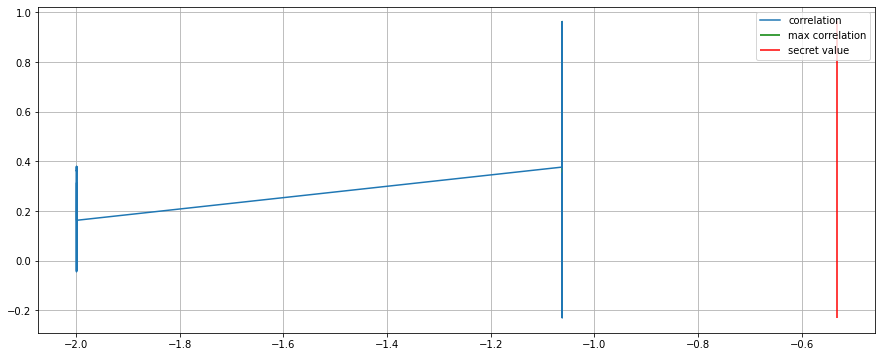

In [338]:
ax = mantisa_corr.sort_index().plot(figsize=(15,6), label='correlation')
ax.vlines(mantisa_corr.idxmax(), mantisa_corr.min(), mantisa_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, mantisa_corr.min(), mantisa_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [339]:
mantisa_corr.iloc[:number_of_best_candidates]

-1.062057    0.963762
-1.062057    0.963762
-1.062057    0.963762
-1.062057    0.963762
-1.062057    0.963762
-1.062057    0.963762
-1.062088    0.906525
-1.062088    0.906525
-1.062088    0.906525
-1.062088    0.906525
dtype: float64

### Correlation exponent

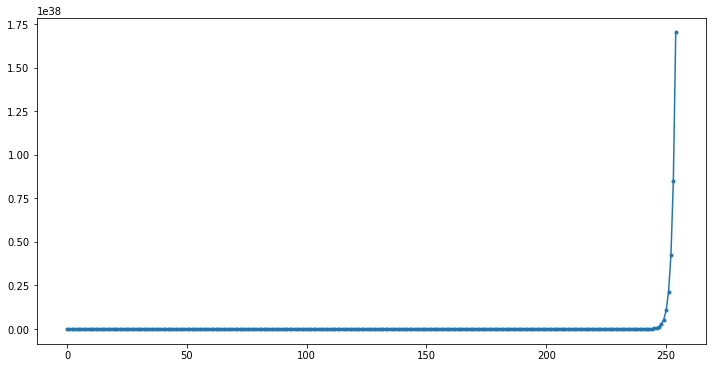

In [340]:
known_inputs = build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
guess_numbers = build_guess_values(component='exponent')
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(12,6), marker='.')

In [341]:
%%time
mantisa_exp_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)

CPU times: user 85.2 ms, sys: 0 ns, total: 85.2 ms
Wall time: 84.2 ms


../pybatina/weight_recovery.py:85: RuntimeWarning: invalid value encountered in multiply
  data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_numbers))
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


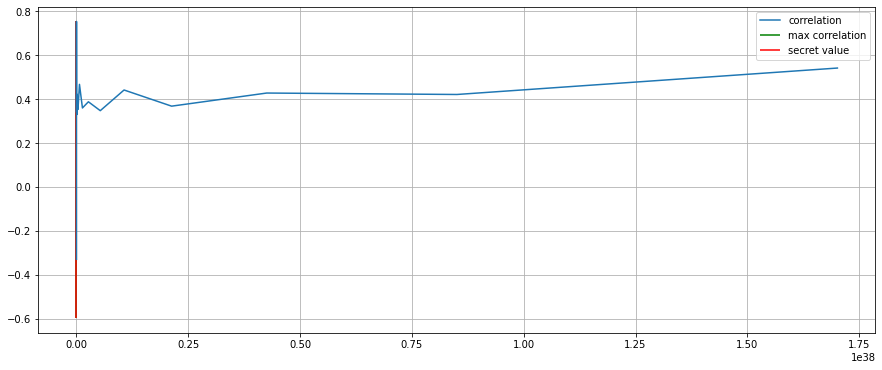

In [342]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6), label='correlation')
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [343]:
print('secret_number:', secret_number)
mantisa_exp_corr.iloc[:number_of_best_candidates]

secret_number: -0.531028635


5.000000e-01    0.753393
2.147484e+09    0.630364
9.223372e+18    0.619655
1.164153e-10    0.610759
3.276800e+04    0.598934
7.629395e-06    0.581467
2.710505e-20    0.573850
3.961408e+28    0.564299
1.407375e+14    0.555848
1.280000e+02    0.548343
dtype: float64

### combine

In [344]:
int_mantissa = np.vectorize(lambda x: float_to_int(x) & (~(0xff << 23)))(mantisa_corr.index[:number_of_best_candidates])
int_exponent = np.vectorize(float_to_int)(mantisa_exp_corr.index[:number_of_best_candidates])
int_guess_numbers = (int_mantissa | int_exponent[:, np.newaxis]).reshape(-1)
guess_numbers = np.vectorize(int_to_float)(int_guess_numbers)
guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= guess_range[0], guess_numbers <= guess_range[1]))]

In [345]:
guess_numbers

array([-5.31028628e-01, -5.31028628e-01, -5.31028628e-01, -5.31028628e-01,
       -5.31028628e-01, -5.31028628e-01, -5.31043887e-01, -5.31043887e-01,
       -5.31043887e-01, -5.31043887e-01, -1.23639737e-10, -1.23639737e-10,
       -1.23639737e-10, -1.23639737e-10, -1.23639737e-10, -1.23639737e-10,
       -1.23643290e-10, -1.23643290e-10, -1.23643290e-10, -1.23643290e-10,
       -8.10285383e-06, -8.10285383e-06, -8.10285383e-06, -8.10285383e-06,
       -8.10285383e-06, -8.10285383e-06, -8.10308666e-06, -8.10308666e-06,
       -8.10308666e-06, -8.10308666e-06, -2.87871196e-20, -2.87871196e-20,
       -2.87871196e-20, -2.87871196e-20, -2.87871196e-20, -2.87871196e-20,
       -2.87879468e-20, -2.87879468e-20, -2.87879468e-20, -2.87879468e-20])

### Check

In [346]:
known_inputs = np.random.uniform(guess_range[0], guess_range[1], 1000)
# known_inputs = build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
check_mantisa_corr = compute_corr_numbers(secret_hw, known_inputs=known_inputs, guess_numbers=guess_numbers).sort_values(ascending=False)

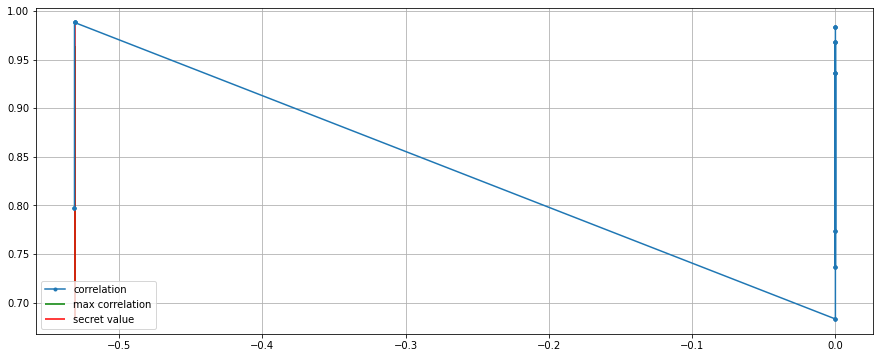

In [347]:
ax = check_mantisa_corr.sort_index().plot(figsize=(15,6), label='correlation', marker='.')
ax.vlines(check_mantisa_corr.idxmax(), check_mantisa_corr.min(), mantisa_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, check_mantisa_corr.min(), check_mantisa_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [348]:
check_mantisa_corr.iloc[:number_of_best_candidates]

-5.310286e-01    0.988248
-5.310286e-01    0.988248
-5.310286e-01    0.988248
-5.310286e-01    0.988248
-5.310286e-01    0.988248
-5.310286e-01    0.988248
-2.878712e-20    0.983468
-2.878712e-20    0.983468
-2.878712e-20    0.983468
-2.878712e-20    0.983468
dtype: float64

In [349]:
a = check_mantisa_corr.iloc[:number_of_best_candidates]
print('{:032b}'.format(float_to_int(secret_number)), '%.08f' % secret_number, hamming_weight(secret_number))
idx = 0
print('{:032b}'.format(float_to_int(a.index[idx])), '%.08f' % a.index[idx], hamming_weight(a.index[idx]))
idx = 3
print('{:032b}'.format(float_to_int(a.index[idx])), '%.08f' % a.index[idx], hamming_weight(a.index[idx]))

10111111000001111111000101111110 -0.53102863 21
10111111000001111111000101111110 -0.53102863 21
10111111000001111111000101111110 -0.53102863 21
